## Introdução
Este projeto tem como objetivo realizar uma análise experimental detalhada utilizando técnicas de aprendizado de máquina para prever sobreviventes do desastre do Titanic, utilizando o famoso dataset "Titanic - Machine Learning from Disaster". O foco principal será na variação de parâmetros essenciais no treinamento de modelos, garantindo uma abordagem sistemática e rigorosa para otimizar o desempenho preditivo.

Objetivos do Projeto
- Explorar e comparar diferentes configurações de redes neurais, incluindo variações no número de camadas intermediárias (1 ou 2), inicialmente optando por redes menores para evitar - complexidade desnecessária.
- Investigar o impacto de diferentes taxas de aprendizagem, funções de ativação e otimizadores nos resultados preditivos.
- Garantir que os dados estejam normalizados para facilitar o treinamento e melhorar a convergência dos modelos (usando normalização Min-Max quando necessário).
- Avaliar o desempenho dos modelos utilizando métricas padrão como Acurácia, Precision e Recall.
- Documentar todos os experimentos de forma clara e reproducível, entregando tanto o notebook Jupyter quanto o relatório em PDF com análises detalhadas e conclusões.
- Participantes do Projeto

#### **Este projeto é realizado pelos seguintes participantes**:

- Alberto Guevara (agaf2)
- Felipe Ferreira da Silva Santos (ffss)      
- Heitor de Assis Machado (ham5)
- João Victor Lopes (jvcl)
- Matheus Veras Batista (mvb2)

## Import Libraries


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Processamento dos dados
Carregamos o dataset do Titanic a partir de um arquivo CSV localizado em um diretório específico. Para que o notebook funcione em qualquer ambiente, é importante usar um caminho relativo:

In [5]:
import os
from pathlib import Path
import pandas as pd

# Verifica se está no Google Colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = Path('/content/drive/My Drive/Titanic-ML-Experiment/data')
else:
    base_path = Path().absolute() / 'data'

# Caminhos dos arquivos de dados
train_path = base_path / 'train.csv'

In [6]:
# Tratamento dos Dados
titanic_data = pd.read_csv(train_path)

In [7]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
#Analisando o número de dados faltantes por coluna
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Lidando com os missing values

- Removemos a coluna 'Cabin' porque possui muitos valores ausentes, dificultando a imputação ou substituição desses dados de forma confiável.
- Preenchemos os valores ausentes na coluna 'Age' com a média das idades, uma técnica comum para lidar com missing values em dados numéricos.
- Substituímos os valores ausentes na coluna 'Embarked' pelo valor mais frequente (moda), uma técnica comum para dados categóricos.



In [9]:
#Vamos retirar a célula 'Cabin'
titanic_data = titanic_data.drop('Cabin', axis=1)

In [10]:
#Vamos substituir a parte faltante em 'Age' pela média
titanic_data['Age'].fillna(titanic_data['Age'].mean(), inplace=True)

In [11]:
#Encontrar o valor da moda da coluna 'Embarked'
print(titanic_data['Embarked'].mode())

0    S
Name: Embarked, dtype: object


In [12]:
#Vamos substituir os valores da coluna 'Embarked' pelo valor da moda
titanic_data['Embarked'].fillna(titanic_data['Embarked'].mode()[0], inplace=True)

In [13]:
#Checar se ainda existe missing values
titanic_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [14]:
#Selecionamos apenas os atributos numericos
numeric_data = titanic_data.select_dtypes(include=[np.number])

<Axes: >

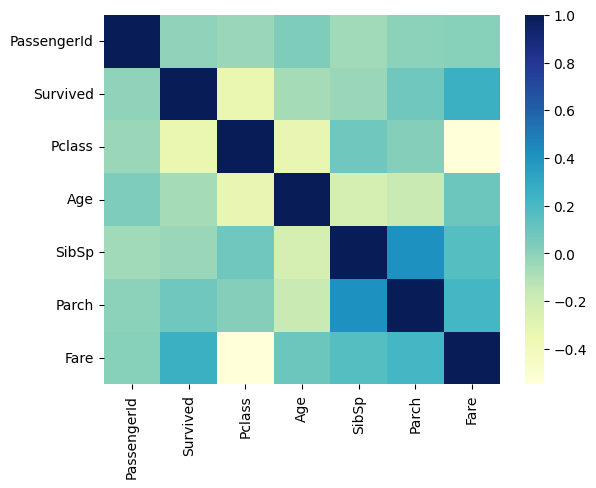

In [15]:
sns.heatmap(numeric_data.corr(), cmap='YlGnBu')

#### Fazendo algumas análises no dataset

In [16]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [17]:
#Número de sobreviventes ou não
titanic_data['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [18]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


Visualização

In [19]:
sns.set_theme()

<Axes: xlabel='Survived', ylabel='count'>

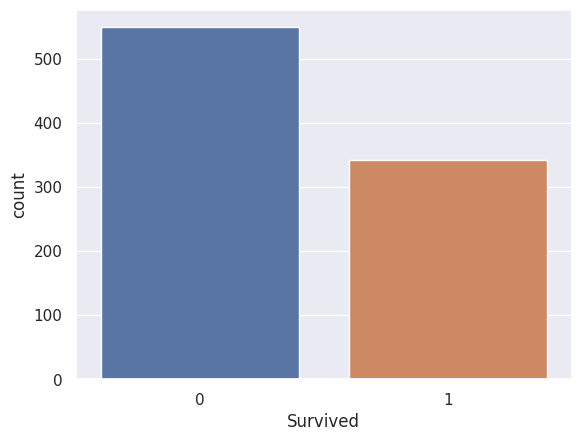

In [20]:
sns.countplot(x = 'Survived', data=titanic_data)

In [21]:
#Número de homens e mulheres
titanic_data['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

<Axes: xlabel='Sex', ylabel='count'>

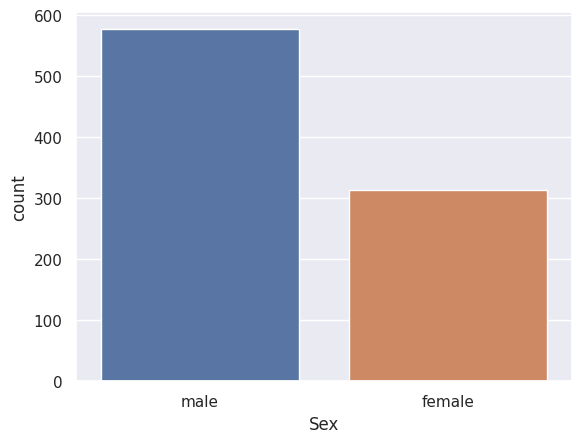

In [22]:
sns.countplot(x = 'Sex', data=titanic_data)

AttributeError: 'numpy.int64' object has no attribute 'startswith'

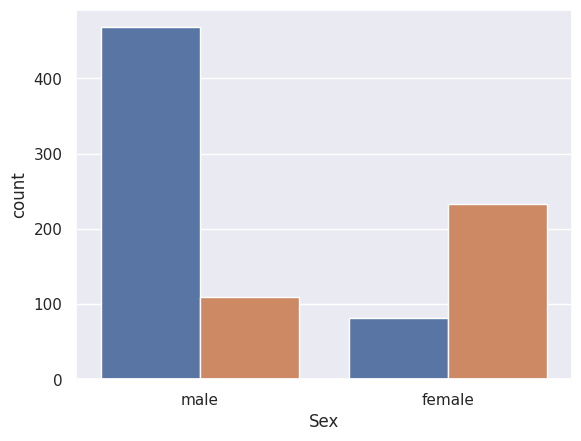

In [24]:
# Numero de sobreviventes por genero
sns.countplot(x='Sex', hue='Survived', data=titanic_data)

<Axes: xlabel='Pclass', ylabel='count'>

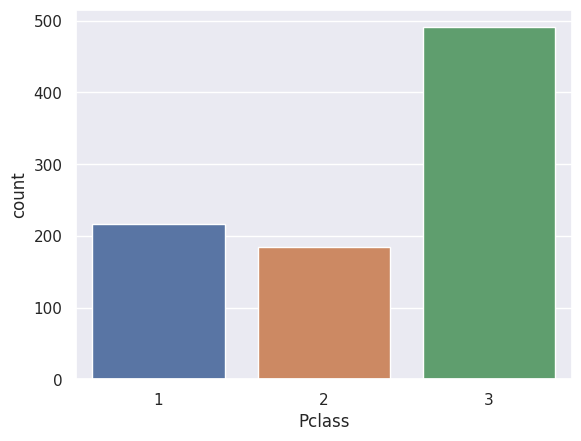

In [25]:
#coluna Pclass
sns.countplot(x='Pclass', data=titanic_data)

AttributeError: 'numpy.int64' object has no attribute 'startswith'

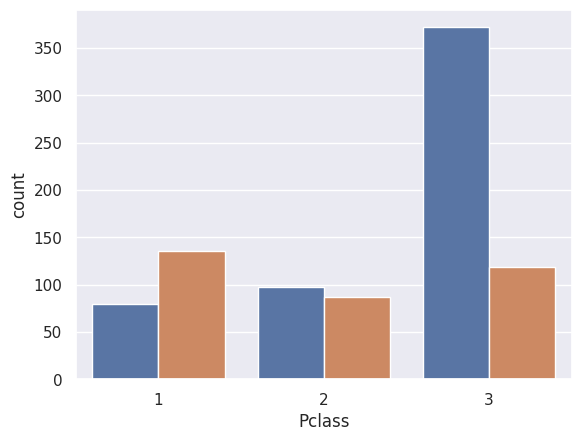

In [26]:
# Numero de sobreviventes por classe
sns.countplot(x='Pclass', hue='Survived', data=titanic_data)

In [27]:
#Selecionamos apenas os atributos numericos
numeric_data = titanic_data.select_dtypes(include=[np.number])

### Convertendo colunas com atributos categóricos

In [28]:
titanic_data.replace({'Sex':{'male': 0, 'female': 1}, 'Embarked':{'S': 0, 'C': 1, 'Q': 2}}, inplace=True)

In [29]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0


In [30]:
# Normalização dos dados numéricos
scaler = MinMaxScaler()
numeric_columns = titanic_data.select_dtypes(include=[np.number]).columns
titanic_data[numeric_columns] = scaler.fit_transform(titanic_data[numeric_columns])

Codificamos variáveis categóricas em variáveis dummy (one-hot encoding) para uso em modelos de machine learning.

In [31]:
# Codificação de variáveis categóricas
titanic_data = pd.get_dummies(titanic_data, drop_first=True)


In [32]:
# Separando os dados em treino e teste
X = titanic_data.drop('Survived', axis=1)
Y = titanic_data['Survived']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [33]:
print(X.shape, X_train.shape, X_test.shape)

(891, 1578) (712, 1578) (179, 1578)


## Treinamento do modelo

A ideia principal da equipe foi gerar vários cenários empiricos com parâmetros diferentes para a mesma rede neural, no caso desse projeto foi abordado MLP.

No conjunto de redes, cada elemento pertencente assume uma peculiaridade específica. Neste trabalho foi análisado níveis de camada intermédiaria da rede, função de ativação, taxa de aprendizagem e solvers [1].

O grupo optou por seguir estritamente a documentação da função MLP da biblioteca sugerida para o projeto. Assim foi implementado redes com as seguintes funções de ativação, taxa de aprendizagem e solver:

| Função de Ativação | Taxa de aprendizagem | Solver |
|--------------------|----------------------|--------|
| relu               | constant             | lbfgs  |
| tanh               | invscaling           | sgd    |
| identity           | adaptive             | adam   |
| logistic           |                      |        |

Para isso dividimos nas seguintes etapas:

- Geração do conjunto de parâmetros;
- Geração de um "log" de resultados;
- Avaliação do conjunto de parâmetros.

In [34]:
# Função para treinar e avaliar o modelo
def train_and_evaluate(clf, X_train, Y_train, X_test, Y_test):
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    return accuracy, precision, recall

* Acima descrevemos uma função de avaliação do desempenho da rede neural.
* As próximas linhas contém a implementação e os resultados do desempenho de cada rede.

In [44]:
# Dicionário para armazenar os resultados
results = {}

# Treinamento e avaliação para cada combinação de função de ativação e taxa de aprendizagem
classifiers = {
    'relu_constant_lbfgs': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', learning_rate='constant', solver='lbfgs', max_iter=1000),
    'relu_constant_sgd': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', learning_rate='constant', solver='sgd', max_iter=1000),
    'relu_constant_adam': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', learning_rate='constant', solver='adam', max_iter=1000),
    'relu_invscaling_lbfgs': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', learning_rate='invscaling', solver='lbfgs', max_iter=1000),
    'relu_invscaling_sgd': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', learning_rate='invscaling', solver='sgd', max_iter=1000),
    'relu_invscaling_adam': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', learning_rate='invscaling', solver='adam', max_iter=1000),
    'relu_adaptive_lbfgs': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', learning_rate='adaptive', solver='lbfgs', max_iter=1000),
    'relu_adaptive_sgd': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', learning_rate='adaptive', solver='sgd', max_iter=1000),
    'relu_adaptive_adam': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', learning_rate='adaptive', solver='adam', max_iter=1000),
    'tanh_constant_lbfgs': MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', learning_rate='constant', solver='lbfgs', max_iter=1000),
    'tanh_constant_sgd': MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', learning_rate='constant', solver='sgd', max_iter=1000),
    'tanh_constant_adam': MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', learning_rate='constant', solver='adam', max_iter=1000),
    'tanh_invscaling_lbfgs': MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', learning_rate='invscaling', solver='lbfgs', max_iter=1000),
    'tanh_invscaling_sgd': MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', learning_rate='invscaling', solver='sgd', max_iter=1000),
    'tanh_invscaling_adam': MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', learning_rate='invscaling', solver='adam', max_iter=1000),
    'tanh_adaptive_lbfgs': MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', learning_rate='adaptive', solver='lbfgs', max_iter=1000),
    'tanh_adaptive_sgd': MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', learning_rate='adaptive', solver='sgd', max_iter=1000),
    'tanh_adaptive_adam': MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', learning_rate='adaptive', solver='adam', max_iter=1000),
    'identity_constant_lbfgs': MLPClassifier(hidden_layer_sizes=(100,), activation='identity', learning_rate='constant', solver='lbfgs', max_iter=1000),
    'identity_constant_sgd': MLPClassifier(hidden_layer_sizes=(100,), activation='identity', learning_rate='constant', solver='sgd', max_iter=1000),
    'identity_constant_adam': MLPClassifier(hidden_layer_sizes=(100,), activation='identity', learning_rate='constant', solver='adam', max_iter=1000),
    'identity_invscaling_lbfgs': MLPClassifier(hidden_layer_sizes=(100,), activation='identity', learning_rate='invscaling', solver='lbfgs', max_iter=1000),
    'identity_invscaling_sgd': MLPClassifier(hidden_layer_sizes=(100,), activation='identity', learning_rate='invscaling', solver='sgd', max_iter=1000),
    'identity_invscaling_adam': MLPClassifier(hidden_layer_sizes=(100,), activation='identity', learning_rate='invscaling', solver='adam', max_iter=1000),
    'identity_adaptive_lbfgs': MLPClassifier(hidden_layer_sizes=(100,), activation='identity', learning_rate='adaptive', solver='lbfgs', max_iter=1000),
    'identity_adaptive_sgd': MLPClassifier(hidden_layer_sizes=(100,), activation='identity', learning_rate='adaptive', solver='sgd', max_iter=1000),
    'identity_adaptive_adam': MLPClassifier(hidden_layer_sizes=(100,), activation='identity', learning_rate='adaptive', solver='adam', max_iter=1000),
    'logistic_constant_lbfgs': MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', learning_rate='constant', solver='lbfgs', max_iter=1000),
    'logistic_constant_sgd': MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', learning_rate='constant', solver='sgd', max_iter=1000),
    'logistic_constant_adam': MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', learning_rate='constant', solver='adam', max_iter=1000),
    'logistic_invscaling_lbfgs': MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', learning_rate='invscaling', solver='lbfgs', max_iter=1000),
    'logistic_invscaling_sgd': MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', learning_rate='invscaling', solver='sgd', max_iter=1000),
    'logistic_invscaling_adam': MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', learning_rate='invscaling', solver='adam', max_iter=1000),
    'logistic_adaptive_lbfgs': MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', learning_rate='adaptive', solver='lbfgs', max_iter=1000),
    'logistic_adaptive_sgd': MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', learning_rate='adaptive', solver='sgd', max_iter=1000),
    'logistic_adaptive_adam': MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', learning_rate='adaptive', solver='adam', max_iter=1000)
}

In [45]:
# Calculando e armazenando as métricas
for name, clf in classifiers.items():
    accuracy, precision, recall = train_and_evaluate(clf, X_train, Y_train, X_test, Y_test)
    results[name] = {'accuracy': accuracy, 'precision': precision, 'recall': recall}

/home/lypess/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lypess/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lypess/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lypess/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lypess/.local/lib/python3.10/site-pack

In [46]:
# Exibindo os resultados
for name, metrics in results.items():
    print(f"Classifier: {name}")
    print(f"  Accuracy: {metrics['accuracy']}")
    print(f"  Precision: {metrics['precision']}")
    print(f"  Recall: {metrics['recall']}")
    print()

Classifier: relu_constant_lbfgs
  Accuracy: 0.8379888268156425
  Precision: 0.8169014084507042
  Recall: 0.7837837837837838

Classifier: relu_constant_sgd
  Accuracy: 0.7988826815642458
  Precision: 0.7794117647058824
  Recall: 0.7162162162162162

Classifier: relu_constant_adam
  Accuracy: 0.8324022346368715
  Precision: 0.8666666666666667
  Recall: 0.7027027027027027

Classifier: relu_invscaling_lbfgs
  Accuracy: 0.8547486033519553
  Precision: 0.8333333333333334
  Recall: 0.8108108108108109

Classifier: relu_invscaling_sgd
  Accuracy: 0.4245810055865922
  Precision: 0.41714285714285715
  Recall: 0.9864864864864865

Classifier: relu_invscaling_adam
  Accuracy: 0.8324022346368715
  Precision: 0.8666666666666667
  Recall: 0.7027027027027027

Classifier: relu_adaptive_lbfgs
  Accuracy: 0.8491620111731844
  Precision: 0.8507462686567164
  Recall: 0.7702702702702703

Classifier: relu_adaptive_sgd
  Accuracy: 0.8100558659217877
  Precision: 0.7857142857142857
  Recall: 0.7432432432432432

C

In [51]:
# Dicionário para armazenar os novos resultados
new_results2 = {}

# Adicionando mais uma camada
classifiers = {
    'relu_constant_lbfgs': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', learning_rate='constant', solver='lbfgs', max_iter=1000),
    'relu_constant_sgd': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', learning_rate='constant', solver='sgd', max_iter=1000),
    'relu_constant_adam': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', learning_rate='constant', solver='adam', max_iter=1000),
    'relu_invscaling_lbfgs': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', learning_rate='invscaling', solver='lbfgs', max_iter=1000),
    'relu_invscaling_sgd': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', learning_rate='invscaling', solver='sgd', max_iter=1000),
    'relu_invscaling_adam': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', learning_rate='invscaling', solver='adam', max_iter=1000),
    'relu_adaptive_lbfgs': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', learning_rate='adaptive', solver='lbfgs', max_iter=1000),
    'relu_adaptive_sgd': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', learning_rate='adaptive', solver='sgd', max_iter=1000),
    'relu_adaptive_adam': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', learning_rate='adaptive', solver='adam', max_iter=1000),
    'tanh_constant_lbfgs': MLPClassifier(hidden_layer_sizes=(100, 50), activation='tanh', learning_rate='constant', solver='lbfgs', max_iter=1000),
    'tanh_constant_sgd': MLPClassifier(hidden_layer_sizes=(100, 50), activation='tanh', learning_rate='constant', solver='sgd', max_iter=1000),
    'tanh_constant_adam': MLPClassifier(hidden_layer_sizes=(100, 50), activation='tanh', learning_rate='constant', solver='adam', max_iter=1000),
    'tanh_invscaling_lbfgs': MLPClassifier(hidden_layer_sizes=(100, 50), activation='tanh', learning_rate='invscaling', solver='lbfgs', max_iter=1000),
    'tanh_invscaling_sgd': MLPClassifier(hidden_layer_sizes=(100, 50), activation='tanh', learning_rate='invscaling', solver='sgd', max_iter=1000),
    'tanh_invscaling_adam': MLPClassifier(hidden_layer_sizes=(100, 50), activation='tanh', learning_rate='invscaling', solver='adam', max_iter=1000),
    'tanh_adaptive_lbfgs': MLPClassifier(hidden_layer_sizes=(100, 50), activation='tanh', learning_rate='adaptive', solver='lbfgs', max_iter=1000),
    'tanh_adaptive_sgd': MLPClassifier(hidden_layer_sizes=(100, 50), activation='tanh', learning_rate='adaptive', solver='sgd', max_iter=1000),
    'tanh_adaptive_adam': MLPClassifier(hidden_layer_sizes=(100, 50), activation='tanh', learning_rate='adaptive', solver='adam', max_iter=1000),
    'identity_constant_lbfgs': MLPClassifier(hidden_layer_sizes=(100, 50), activation='identity', learning_rate='constant', solver='lbfgs', max_iter=1000),
    'identity_constant_sgd': MLPClassifier(hidden_layer_sizes=(100, 50), activation='identity', learning_rate='constant', solver='sgd', max_iter=1000),
    'identity_constant_adam': MLPClassifier(hidden_layer_sizes=(100, 50), activation='identity', learning_rate='constant', solver='adam', max_iter=1000),
    'identity_invscaling_lbfgs': MLPClassifier(hidden_layer_sizes=(100, 50), activation='identity', learning_rate='invscaling', solver='lbfgs', max_iter=1000),
    'identity_invscaling_sgd': MLPClassifier(hidden_layer_sizes=(100, 50), activation='identity', learning_rate='invscaling', solver='sgd', max_iter=1000),
    'identity_invscaling_adam': MLPClassifier(hidden_layer_sizes=(100, 50), activation='identity', learning_rate='invscaling', solver='adam', max_iter=1000),
    'identity_adaptive_lbfgs': MLPClassifier(hidden_layer_sizes=(100, 50), activation='identity', learning_rate='adaptive', solver='lbfgs', max_iter=1000),
    'identity_adaptive_sgd': MLPClassifier(hidden_layer_sizes=(100, 50), activation='identity', learning_rate='adaptive', solver='sgd', max_iter=1000),
    'identity_adaptive_adam': MLPClassifier(hidden_layer_sizes=(100, 50), activation='identity', learning_rate='adaptive', solver='adam', max_iter=1000),
    'logistic_constant_lbfgs': MLPClassifier(hidden_layer_sizes=(100, 50), activation='logistic', learning_rate='constant', solver='lbfgs', max_iter=1000),
    'logistic_constant_sgd': MLPClassifier(hidden_layer_sizes=(100, 50), activation='logistic', learning_rate='constant', solver='sgd', max_iter=1000),
    'logistic_constant_adam': MLPClassifier(hidden_layer_sizes=(100, 50), activation='logistic', learning_rate='constant', solver='adam', max_iter=1000),
    'logistic_invscaling_lbfgs': MLPClassifier(hidden_layer_sizes=(100, 50), activation='logistic', learning_rate='invscaling', solver='lbfgs', max_iter=1000),
    'logistic_invscaling_sgd': MLPClassifier(hidden_layer_sizes=(100, 50), activation='logistic', learning_rate='invscaling', solver='sgd', max_iter=1000),
    'logistic_invscaling_adam': MLPClassifier(hidden_layer_sizes=(100, 50), activation='logistic', learning_rate='invscaling', solver='adam', max_iter=1000),
    'logistic_adaptive_lbfgs': MLPClassifier(hidden_layer_sizes=(100, 50), activation='logistic', learning_rate='adaptive', solver='lbfgs', max_iter=1000),
    'logistic_adaptive_sgd': MLPClassifier(hidden_layer_sizes=(100, 50), activation='logistic', learning_rate='adaptive', solver='sgd', max_iter=1000),
    'logistic_adaptive_adam': MLPClassifier(hidden_layer_sizes=(100, 50), activation='logistic', learning_rate='adaptive', solver='adam', max_iter=1000)
}

In [52]:
# Calculando e armazenando as métricas
for name, clf in classifiers.items():
    accuracy, precision, recall = train_and_evaluate(clf, X_train, Y_train, X_test, Y_test)
    new_results2[name] = {'accuracy': accuracy, 'precision': precision, 'recall': recall}

/home/lypess/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lypess/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lypess/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lypess/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn

In [53]:
# Exibindo os resultados
for name, metrics in new_results2.items():
    print(f"Classifier: {name}")
    print(f"  Accuracy: {metrics['accuracy']}")
    print(f"  Precision: {metrics['precision']}")
    print(f"  Recall: {metrics['recall']}")
    print()

Classifier: relu_constant_lbfgs
  Accuracy: 0.8491620111731844
  Precision: 0.8051948051948052
  Recall: 0.8378378378378378

Classifier: relu_constant_sgd
  Accuracy: 0.8379888268156425
  Precision: 0.835820895522388
  Recall: 0.7567567567567568

Classifier: relu_constant_adam
  Accuracy: 0.8324022346368715
  Precision: 0.8548387096774194
  Recall: 0.7162162162162162

Classifier: relu_invscaling_lbfgs
  Accuracy: 0.8435754189944135
  Precision: 0.7948717948717948
  Recall: 0.8378378378378378

Classifier: relu_invscaling_sgd
  Accuracy: 0.5865921787709497
  Precision: 0.0
  Recall: 0.0

Classifier: relu_invscaling_adam
  Accuracy: 0.8324022346368715
  Precision: 0.8666666666666667
  Recall: 0.7027027027027027

Classifier: relu_adaptive_lbfgs
  Accuracy: 0.8603351955307262
  Precision: 0.8356164383561644
  Recall: 0.8243243243243243

Classifier: relu_adaptive_sgd
  Accuracy: 0.8268156424581006
  Precision: 0.8028169014084507
  Recall: 0.7702702702702703

Classifier: relu_adaptive_adam
  

Para determinar qual conjunto de resultados de classificadores foi o melhor entre os dois conjuntos apresentados, consideraremos as métricas de avaliação: accuracy (acurácia), precision (precisão) e recall (recobertura). A seguir, faremos uma análise detalhada de cada métrica.
Análise de Métricas

## Accuracy

A acurácia mede a proporção de previsões corretas em relação ao total de previsões feitas.

    Resultado 1: A acurácia máxima foi de 86.03% (identity_constant_lbfgs, identity_invscaling_lbfgs).
    Resultado 2: A acurácia máxima foi de 86.59% (identity_invscaling_lbfgs).

## Precision

A precisão é a proporção de previsões positivas corretas em relação ao total de previsões positivas feitas.

    Resultado 1: A precisão máxima foi de 100% (tanh_invscaling_sgd).
    Resultado 2: A precisão máxima foi de 87.30% (logistic_constant_lbfgs).

## Recall

O recall é a proporção de verdadeiros positivos identificados corretamente em relação ao total de positivos reais.

    Resultado 1: O recall máximo foi de 98.65% (relu_invscaling_sgd).
    Resultado 2: O recall máximo foi de 100% (logistic_invscaling_sgd).

# Discussão

Com base nas métricas acima, o conjunto de resultados 2 apresenta valores ligeiramente superiores em termos de acurácia e recall, sendo 86.59% para acurácia e 100% para recall. No entanto, devemos considerar que algumas combinações no conjunto de resultados 1 apresentam alta precisão e acurácia, como identity_constant_lbfgs, que possui 86.03% de acurácia e 84.51% de precisão.

## Considerações na Literatura

A literatura em aprendizado de máquina enfatiza que a escolha do melhor modelo não deve ser feita apenas com base em uma única métrica, mas sim em um equilíbrio entre várias métricas, dependendo do contexto da aplicação. Por exemplo, em cenários onde a detecção de todos os positivos é crucial (como em diagnósticos médicos), o recall pode ser mais importante do que a precisão [2,3,4].

Além disso, métodos de otimização como Grid Search ou Random Search podem ser utilizados para ajustar hiperparâmetros e encontrar a melhor combinação de métricas.

Referências Bibliograficas:

[1] SCIKIT-LEARN. Multi-layer Perceptron classifier. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html. Acesso em: 24/06/2024.

[2] BISHOP, Christopher M. Pattern Recognition and Machine Learning. 1. ed. New York: Springer, 2006. ISBN 978-0-387-31073-2.

[3] GOODFELLOW, Ian; BENGIO, Yoshua; COURVILLE, Aaron. Deep Learning. 1. ed. Cambridge: MIT Press, 2016. ISBN 978-0-262-03561-3.

[4] PEDREGOSA, Fabian et al. Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, v. 12, p. 2825-2830, 2011. Disponível em: http://jmlr.csail.mit.edu/papers/volume12/pedregosa11a/pedregosa11a.pdf. Acesso em: 24/06/2024.